In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import torch

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F


from fase.nn.conv import *

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

ModuleNotFoundError: No module named 'fase'

In [ ]:
num_workers = 0
batch_size = 32
valid_size = 0.2


## Scale 
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True,
                              transform=transform
                             )
test_data = datasets.CIFAR10('data', train=False,
                             download=True, 
                             transform=transform
                            )

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
from approximate import approx_relu, approx_sign

xfactor = 20

activation = lambda x : xfactor * approx_relu(x/xfactor, degree = 5, repeat=3)

from fase.nn.models import ConvNeuralNet

org_model = ConvNeuralNet(num_classes=10, activation=F.relu) # F.relu가 아니고..??

# FHE

In [3]:
#import fase
from fase.core import seal_ckks
from fase.core.seal_ckks import SEALContext
from fase.seal import Ciphertext
import fase.nn.utils as utils

from fase.core import commonAlgo
from fase.core.commonAlgo import CommonAlgorithms
from numpy import polynomial as P

ModuleNotFoundError: No module named 'fase'

poly_modulus_degree = 16384
coeff_moduli = [37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=28)

정확도를 높이려면 더 많은 bit가 필요함. [60, 40, ...., 60?]

In [4]:
poly_modulus_degree = 2**15
scale_bit = 50
coeff_moduli = [60] + [scale_bit] * 14 + [60]

sec = SEALContext(poly_modulus_degree=poly_modulus_degree,
                             coeff_moduli=coeff_moduli,
                             scale_bit=scale_bit)

util = utils.Seal_checker(sec)

NameError: name 'SEALContext' is not defined

## Load trained parameters

In [5]:
fn_param = "SimpleCNN_ReLU_minimax_v2.pt"

trained_param = torch.load(fn_param, map_location=torch.device(device))
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

NameError: name 'device' is not defined

In [8]:
org_model

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Load image

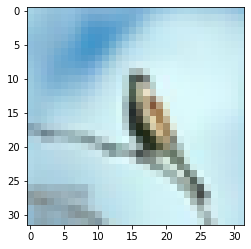

In [25]:
plt.imshow(img)

In [20]:
imgs, labels = next(iter(test_loader))

## Orginal model's prediction

In [11]:
predictions = org_model(imgs)
print(predictions.shape)
print(predictions[0], labels[0])

torch.Size([32, 10])
tensor([  1.6387,   3.3497, -11.8637,  14.3675, -15.4812,   8.2658,  -8.6026,
         -7.4570,   2.9418,  11.7727], grad_fn=<SelectBackward0>) tensor(3)


In [27]:
import torchvision.transforms as transforms

img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

sec.decrypt(img_enc[0])

torch.Size([1, 3, 32, 32])


array([ 6.50980413e-01,  6.31372571e-01,  6.11764729e-01, ...,
       -3.48694106e-12, -1.44585277e-13,  3.53778626e-12])

In [26]:
tmp1, _nh2, _nw2 = my_conv2D_FHE(sec, img_enc, nh, nw, org_model.conv_layer1) # list of ctxts
util.plot_diff(org_tt1, tmp1, 32,32, ch=5, unpad=0)
util.check_ctxt(tmp1[0])
print("1. expected chain index = 12")
print(f"{time() - t0:.3f} seconds so far")

Output image size 32 32
Rotating... 3 3 0 0 -33
Rotating... 3 3 0 1 -32
Rotating... 3 3 0 2 -31
Rotating... 3 3 1 0 -1
Rotating... 3 3 1 1 0
Rotating... 3 3 1 2 1
Rotating... 3 3 2 0 31
Rotating... 3 3 2 1 32
Rotating... 3 3 2 2 33
Rotating... 3 3 0 0 -33
Rotating... 3 3 0 1 -32
Rotating... 3 3 0 2 -31
Rotating... 3 3 1 0 -1
Rotating... 3 3 1 1 0
Rotating... 3 3 1 2 1
Rotating... 3 3 2 0 31
Rotating... 3 3 2 1 32
Rotating... 3 3 2 2 33
Rotating... 3 3 0 0 -33
Rotating... 3 3 0 1 -32
Rotating... 3 3 0 2 -31
Rotating... 3 3 1 0 -1
Rotating... 3 3 1 1 0
Rotating... 3 3 1 2 1
Rotating... 3 3 2 0 31
Rotating... 3 3 2 1 32
Rotating... 3 3 2 2 33
[-2.10923404e-09  2.80518540e-10 -2.79286461e-10 ... -3.13265306e-11
  2.63521621e-11 -8.25752355e-11]
[-2.12508024e-09  2.97908090e-10 -2.66655878e-10 ...  1.79568068e-11
 -2.53109069e-11  4.77564989e-11]
[-2.11869561e-09  3.16457041e-10 -2.65009508e-10 ... -3.52808942e-12
  3.14235366e-11 -1.64805506e-11]
[-3.12596112e-09  6.50980412e-01  6.3137257

NameError: name 'org_tt1' is not defined

## Step-by-step Model prediction 

In [84]:
for i in range(3, 10):
    img_tensor = imgs[i:i+1]
    org_tt1 = org_model.conv_layer1(img_tensor)
    org_tt2 = org_model.conv_layer2(org_tt1)
    org_tt3 = org_model.pool(org_tt2)
    org_tt4 = org_model.conv_layer3(org_tt3)
    org_tt5 = org_model.bn1(org_tt4)
    org_tt6 = org_model.activation(org_tt5)
    org_tt7 = org_model.pool(org_tt6)
    org_tt8 = org_model.conv_layer4(org_tt7)
    org_tt9 = org_model.conv_layer5(org_tt8)
    #######################
    org_tt9_1 = org_model.bn2(org_tt9)
    org_tt9_2 = org_model.activation(org_tt9_1)
    #######################
    org_tt10 = org_model.pool(org_tt9_2)
    org_tt10_ = org_tt10.reshape(org_tt10.size(0),-1)
    org_11 = org_model.fc1(org_tt10_)
    org_11_1 = org_model.activation(org_11)
    answer = org_model.fc2(org_11_1)
    print(answer)
    torch.argmax(answer)

    pred = fhe_eval(org_model, sec, img_tensor[0])
    print(pred)
    print("_________\n")

tensor([[ 16.5144,  10.1240,   3.5315,  -5.4633,  -6.6456, -13.2490, -10.0271,
         -10.6792,   8.5306,   7.5610]], grad_fn=<AddmmBackward0>)
Output image size 32 32
conv1... 22.007 seconds
Output image size 32 32
conv2... 212.529 seconds
Output image size 16 16
pool1... 223.039 seconds
Output image size 16 16
conv3... 523.522 seconds
bn1... 524.168 seconds
Bootstrapped 0 2
Bootstrapped 1 2
Bootstrapped 2 2
Bootstrapped 3 2
Bootstrapped 4 2
Bootstrapped 5 2
Bootstrapped 6 2
Bootstrapped 7 2
Bootstrapped 8 2
Bootstrapped 9 2
Bootstrapped 10 2
Bootstrapped 11 2
Bootstrapped 12 2
Bootstrapped 13 2
Bootstrapped 14 2
Bootstrapped 15 2
Bootstrapped 16 2
Bootstrapped 17 2
Bootstrapped 18 2
Bootstrapped 19 2
Bootstrapped 20 2
Bootstrapped 21 2
Bootstrapped 22 2
Bootstrapped 23 2
Bootstrapped 24 2
Bootstrapped 25 2
Bootstrapped 26 2
Bootstrapped 27 2
Bootstrapped 28 2
Bootstrapped 29 2
Bootstrapped 30 2
Bootstrapped 31 2
activation... 631.919 seconds
Output image size 8 8
activation... 650.

Bootstrapped 21 2
Bootstrapped 22 2
Bootstrapped 23 2
Bootstrapped 24 2
Bootstrapped 25 2
Bootstrapped 26 2
Bootstrapped 27 2
Bootstrapped 28 2
Bootstrapped 29 2
Bootstrapped 30 2
Bootstrapped 31 2
activation... 623.752 seconds
Output image size 8 8
activation... 641.950 seconds
Output image size 8 8
conv4... 1362.644 seconds
Output image size 8 8
conv5... 2669.541 seconds
bn2... 2670.920 seconds
Bootstrapped 0 1
Bootstrapped 0 3
Bootstrapped 1 1
Bootstrapped 1 3
Bootstrapped 2 1
Bootstrapped 2 3
Bootstrapped 3 1
Bootstrapped 3 3
Bootstrapped 4 1
Bootstrapped 4 3
Bootstrapped 5 1
Bootstrapped 5 3
Bootstrapped 6 1
Bootstrapped 6 3
Bootstrapped 7 1
Bootstrapped 7 3
Bootstrapped 8 1
Bootstrapped 8 3
Bootstrapped 9 1
Bootstrapped 9 3
Bootstrapped 10 1
Bootstrapped 10 3
Bootstrapped 11 1
Bootstrapped 11 3
Bootstrapped 12 1
Bootstrapped 12 3
Bootstrapped 13 1
Bootstrapped 13 3
Bootstrapped 14 1
Bootstrapped 14 3
Bootstrapped 15 1
Bootstrapped 15 3
Bootstrapped 16 1
Bootstrapped 16 3
Bootstra

Bootstrapped 10 1
Bootstrapped 10 3
Bootstrapped 11 1
Bootstrapped 11 3
Bootstrapped 12 1
Bootstrapped 12 3
Bootstrapped 13 1
Bootstrapped 13 3
Bootstrapped 14 1
Bootstrapped 14 3
Bootstrapped 15 1
Bootstrapped 15 3
Bootstrapped 16 1
Bootstrapped 16 3
Bootstrapped 17 1
Bootstrapped 17 3
Bootstrapped 18 1
Bootstrapped 18 3
Bootstrapped 19 1
Bootstrapped 19 3
Bootstrapped 20 1
Bootstrapped 20 3
Bootstrapped 21 1
Bootstrapped 21 3
Bootstrapped 22 1
Bootstrapped 22 3
Bootstrapped 23 1
Bootstrapped 23 3
Bootstrapped 24 1
Bootstrapped 24 3
Bootstrapped 25 1
Bootstrapped 25 3
Bootstrapped 26 1
Bootstrapped 26 3
Bootstrapped 27 1
Bootstrapped 27 3
Bootstrapped 28 1
Bootstrapped 28 3
Bootstrapped 29 1
Bootstrapped 29 3
Bootstrapped 30 1
Bootstrapped 30 3
Bootstrapped 31 1
Bootstrapped 31 3
Bootstrapped 32 1
Bootstrapped 32 3
Bootstrapped 33 1
Bootstrapped 33 3
Bootstrapped 34 1
Bootstrapped 34 3
Bootstrapped 35 1
Bootstrapped 35 3
Bootstrapped 36 1
Bootstrapped 36 3
Bootstrapped 37 1
Bootstrapp

Bootstrapped 31 1
Bootstrapped 31 3
Bootstrapped 32 1
Bootstrapped 32 3
Bootstrapped 33 1
Bootstrapped 33 3
Bootstrapped 34 1
Bootstrapped 34 3
Bootstrapped 35 1
Bootstrapped 35 3
Bootstrapped 36 1
Bootstrapped 36 3
Bootstrapped 37 1
Bootstrapped 37 3
Bootstrapped 38 1
Bootstrapped 38 3
Bootstrapped 39 1
Bootstrapped 39 3
Bootstrapped 40 1
Bootstrapped 40 3
Bootstrapped 41 1
Bootstrapped 41 3
Bootstrapped 42 1
Bootstrapped 42 3
Bootstrapped 43 1
Bootstrapped 43 3
Bootstrapped 44 1
Bootstrapped 44 3
Bootstrapped 45 1
Bootstrapped 45 3
Bootstrapped 46 1
Bootstrapped 46 3
Bootstrapped 47 1
Bootstrapped 47 3
Bootstrapped 48 1
Bootstrapped 48 3
Bootstrapped 49 1
Bootstrapped 49 3
Bootstrapped 50 1
Bootstrapped 50 3
Bootstrapped 51 1
Bootstrapped 51 3
Bootstrapped 52 1
Bootstrapped 52 3
Bootstrapped 53 1
Bootstrapped 53 3
Bootstrapped 54 1
Bootstrapped 54 3
Bootstrapped 55 1
Bootstrapped 55 3
Bootstrapped 56 1
Bootstrapped 56 3
Bootstrapped 57 1
Bootstrapped 57 3
Bootstrapped 58 1
Bootstrapp

In [83]:
def fhe_eval(org_model, sec, img_this_example):
    calgo = CommonAlgorithms(sec, "SEAL")
    ff = approx_sign(5)
    t0 = time()

    img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]
    nh, nw = img_this_example[0].shape

    tmp1, _nh, _nw = my_conv2D_FHE(sec, img_enc, nh, nw, org_model.conv_layer1) # list of ctxts
    print(f"conv1... {time() - t0:.3f} seconds")

    tmp2, _nh2, _nw2 = my_conv2D_FHE(sec, tmp1, nh, nw, org_model.conv_layer2) # list of ctxts
    print(f"conv2... {time() - t0:.3f} seconds")

    tmp3, nh2, nw2 = fhe_avg_pool(sec, tmp2,
                                    nh, nw, 
                                    kernel_size=org_model.pool.kernel_size, 
                                    stride_in=1) # list of ctxts
    print(f"pool1... {time() - t0:.3f} seconds")
    
    tmp4, _nh2, _nw2 = my_conv2D_FHE(sec, tmp3, nh, nw, org_model.conv_layer3,
                                    stride_in=2) # list of ctxts
    print(f"conv3... {time() - t0:.3f} seconds")
    
    tmp5 = fhe_bn(sec, tmp4, org_model.bn1)
    print(f"bn1... {time() - t0:.3f} seconds")
    tmp5 = [do_bootstrap(sec, tmp) for tmp in tmp5]
    
    tmp6 = approx_relu_fhe(sec, calgo, tmp5, ff, repeat=4, xfactor=20)
    print(f"activation... {time() - t0:.3f} seconds")
    
    tmp6 = [do_bootstrap(sec, tmp) for tmp in tmp6]

    tmp7, _nh3, _nw3 = fhe_avg_pool(sec, tmp6, nh, nw, 
                                    kernel_size=org_model.pool.kernel_size, 
                                    stride_in=2) # list of ctxts
    print(f"activation... {time() - t0:.3f} seconds")

    tmp8, _nh3, _nw3 = my_conv2D_FHE(sec, tmp7, nh, nw, org_model.conv_layer4,
                                    stride_in=4) # list of ctxts
    print(f"conv4... {time() - t0:.3f} seconds")
    tmp9, _nh3, _nw3 = my_conv2D_FHE(sec, tmp8, nh, nw, org_model.conv_layer5,
                                    stride_in=4) # list of ctxts
    print(f"conv5... {time() - t0:.3f} seconds")
    tmp9_1 = fhe_bn(sec, tmp9, org_model.bn2)
    print(f"bn2... {time() - t0:.3f} seconds")
    tmp9_2 = approx_relu_fhe(sec, calgo, tmp9_1, ff, repeat=4, xfactor=20)
    print(f"activation.. {time() - t0:.3f} seconds")
    tmp10, _nh4, _nw4 = fhe_avg_pool(sec, tmp9_2, nh, nw, 
                                    kernel_size=org_model.pool.kernel_size, 
                                    stride_in=4) # list of ctxts
    print(f"pool2... {time() - t0:.3f} seconds")
    reshaped = reshape(sec, tmp10)
    reshaped = do_bootstrap(sec, reshaped)

    tmp_fc1 = fullyConnected1(sec, reshaped, org_model.fc1)
    print(f"FC1... {time() - t0:.3f} seconds")

    tmp_fc1 = [do_bootstrap(sec, tmp_fc1)]
    tmp_fc11 = approx_relu_fhe(sec, calgo, tmp_fc1, ff, repeat=4, xfactor=15)[0]
    print(f"activation... {time() - t0:.3f} seconds")

    result = fullyConnected2(sec, tmp_fc11, org_model.fc2)
    print(f"Done... {time() - t0:.3f} seconds")

    pred = sec.decrypt(result)[:10]
    
    return pred

## FHE prediction

In [67]:
from time import time

In [29]:
org_tt1 = org_model.conv_layer1(img_tensor)
org_tt2 = org_model.conv_layer2(org_tt1)
org_tt3 = org_model.pool(org_tt2)
org_tt4 = org_model.conv_layer3(org_tt3)
org_tt5 = org_model.bn1(org_tt4)
org_tt6 = org_model.activation(org_tt5)
org_tt7 = org_model.pool(org_tt6)
org_tt8 = org_model.conv_layer4(org_tt7)
org_tt9 = org_model.conv_layer5(org_tt8)
#######################
org_tt9_1 = org_model.bn2(org_tt9)
org_tt9_2 = org_model.activation(org_tt9_1)
#######################
org_tt10 = org_model.pool(org_tt9_2)
org_tt10_ = org_tt10.reshape(org_tt10.size(0),-1)
org_11 = org_model.fc1(org_tt10_)
org_11_1 = org_model.activation(org_11)

In [34]:
t0 = time()
img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

tmp1, _nh2, _nw2 = my_conv2D_FHE(sec, img_enc, nh, nw, org_model.conv_layer1) # list of ctxts

Output image size 32 32
[-2.66347080e-12 -1.03683549e-11 -6.24585006e-12 ...  5.91385938e-02
  5.85382020e-02  5.64368308e-02]
[-5.55131891e-13 -1.20082347e-12 -1.79930503e-13 ...  4.55001645e-02
  4.38668254e-02  3.18488218e-14]
[-2.05995748e-12  3.36455553e-03  3.26321350e-03 ...  4.11448651e-03
  3.95233927e-03  3.91180247e-03]
[-0.02286128 -0.02217269 -0.0214841  ... -0.02685512 -0.02657969
 -0.02575337]
[-7.31223240e-02 -7.08514452e-02 -6.81263897e-02 ... -8.76559528e-02
 -8.49308975e-02 -2.70208335e-13]
[ 3.90091595e-13 -4.05919657e-02 -3.93154889e-02 ...  2.85131359e-12
 -1.82860035e-13 -7.10628735e-13]
[-5.28760053e-02 -5.12132382e-02 -4.98830243e-02 ...  1.75316250e-12
  8.62627455e-13 -4.38529762e-12]
[-6.29630144e-02 -6.13276119e-02 -5.88745077e-02 ...  3.02231779e-12
  3.79467301e-12 -1.03084349e-12]
[ 2.66073754e-12  2.59311496e-13 -2.06826705e-12 ...  9.54145300e-02
  9.37904530e-02  9.17603568e-02]
[-3.14266397e-12 -2.33469766e-12  1.70594636e-13 ...  1.01663178e-01
  9.

[-1.45258041e-02 -1.42409845e-02 -1.38849599e-02 ... -1.63771321e-02
 -1.60211075e-02  1.45210374e-12]
[-1.23865124e-13 -4.08423332e-02 -3.94611916e-02 ...  3.63009742e-13
 -7.32273635e-13 -1.30901760e-12]
[-1.17110758e-01 -1.13150492e-01 -1.10321729e-01 ...  3.57209935e-13
 -5.90223716e-13  1.54333219e-13]
[-9.64384996e-02 -9.40275376e-02 -9.16165753e-02 ... -1.10619608e-13
 -1.19841842e-12 -3.02182024e-13]
[ 5.45943368e-12  8.18568883e-13 -7.13744110e-13 ...  6.30824572e-03
  6.28217859e-03  6.20397720e-03]
[-3.14551291e-12 -3.36477279e-12 -1.87376199e-12 ... -3.37035013e-02
 -3.32839556e-02  3.65020377e-12]
[-2.22241828e-12  1.66983358e-02  1.64066619e-02 ...  1.76462762e-02
  1.75733577e-02  1.75004393e-02]
[0.10097944 0.09921561 0.09789273 ... 0.10627094 0.10582998 0.10538902]
[9.78946146e-02 9.65893537e-02 9.52840921e-02 ... 1.04420922e-01
 1.03985835e-01 1.28939949e-12]
[-8.37544213e-13 -6.61652736e-03 -6.52830699e-03 ...  2.27209156e-12
 -2.17844390e-12 -5.03402785e-13]
[-5.637

[ 1.60351682e-12  5.92199708e-12 -1.42888465e-12 ... -1.02097794e-01
 -9.84327454e-02  2.53592759e-13]
[1.08302725e-12 2.15366295e-02 2.08879359e-02 ... 2.63369622e-02
 2.52990525e-02 2.50395750e-02]
[0.11610451 0.11260739 0.10911026 ... 0.13638783 0.13498898 0.13079243]
[-2.91479713e-02 -2.82427551e-02 -2.71564954e-02 ... -3.49413566e-02
 -3.38550969e-02  7.16983547e-13]
[-2.75326689e-12 -2.12729109e-02 -2.06039515e-02 ... -1.07776933e-12
 -1.48631818e-12  1.36429248e-12]
[ 8.99216951e-02  8.70939695e-02  8.48317887e-02 ... -3.03072868e-14
  1.21695748e-12 -3.24413734e-13]
[7.55369506e-03 7.35749525e-03 7.06319546e-03 ... 3.01698964e-12
 8.67735467e-13 3.92827873e-13]
[ 2.45185351e-12  3.87311670e-12 -1.45664311e-12 ...  7.75380325e-03
  7.62182363e-03  7.45684910e-03]
[-1.77800787e-12 -6.78154527e-12 -4.39400647e-12 ... -1.54249000e-01
 -1.50910278e-01  3.51097301e-12]
[1.61442697e-12 9.37631651e-02 9.06525391e-02 ... 1.05316919e-01
 1.03539419e-01 1.02206293e-01]
[0.16180096 0.15643

[ 1.75207637e-02  1.70827447e-02  1.66447257e-02 ...  4.04494011e-14
 -2.46838055e-12 -2.52035939e-13]
[ 1.06881416e-13 -1.61621641e-12 -4.89255447e-12 ...  8.43654891e-02
  8.40168714e-02  8.29710183e-02]
[ 1.42455860e-12 -6.75499800e-12 -3.23579201e-12 ... -7.25509030e-02
 -7.16477798e-02 -1.35249394e-12]
[-1.10725867e-12  9.96099596e-02  9.78700478e-02 ...  1.05264673e-01
  1.04829695e-01  1.04394717e-01]
[0.02208459 0.02169883 0.02140951 ... 0.02324186 0.02314542 0.02304898]
[-6.78419547e-02 -6.69373957e-02 -6.60328363e-02 ... -7.23647516e-02
 -7.20632319e-02  2.07663282e-12]
[ 2.73659647e-13  7.01248370e-02  6.91898392e-02 ... -2.95694895e-12
  5.85100404e-12 -3.34082114e-12]
[-1.24346028e-02 -1.22688081e-02 -1.21030134e-02 ...  1.05840665e-12
 -1.83295001e-13  1.38972138e-13]
[-6.45202300e-02 -6.36483353e-02 -6.24858086e-02 ...  2.01540732e-13
 -1.06663350e-12  4.89689158e-13]
[ 6.35760557e-13 -2.46252056e-12 -1.43351310e-13 ...  9.91317492e-02
  9.81253355e-02  9.46028879e-02]
[

[ 1.02375733e-01  9.91963634e-02  9.53811188e-02 ...  1.22723703e-01
  1.18908459e-01 -7.12927597e-13]
[-1.68852392e-12 -3.51736554e-02 -3.40675657e-02 ... -9.49583312e-13
  3.19397511e-12 -3.50038765e-13]
[1.99888863e-02 1.93603051e-02 1.88574401e-02 ... 1.84699933e-12
 6.11281878e-13 9.41917413e-14]
[-2.20692347e-03 -2.14960080e-03 -2.06361677e-03 ... -1.95795592e-12
  3.10107771e-12 -3.30248449e-13]
[ 2.70412505e-12 -9.35667933e-13  6.32596816e-12 ... -1.05802354e-01
 -1.04001463e-01 -1.01750349e-01]
[ 2.79396006e-12 -6.30665349e-12  2.57510222e-12 ...  4.82646257e-02
  4.72199369e-02 -2.42003318e-13]
[6.74547968e-13 2.12641366e-02 2.05586914e-02 ... 2.38843619e-02
 2.34812503e-02 2.31789166e-02]
[0.07233484 0.06993511 0.06856383 ... 0.07987686 0.07884841 0.07713431]
[ 8.53409422e-02  8.36675910e-02  8.15759013e-02 ...  9.62177286e-02
  9.41260390e-02 -3.28463754e-12]
[-3.56632767e-14  2.45958245e-02  2.37640817e-02 ... -1.35355239e-12
 -1.38539502e-12  8.61854264e-13]
[ 7.35762562e

average diff 0.000 sigma


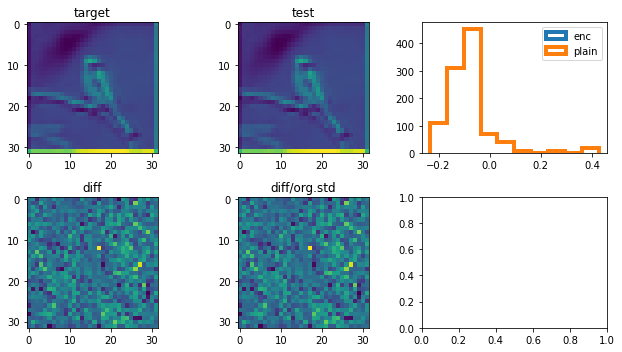

Scale 50.0
chain index 12
1. expected chain index = 12
63.753 seconds so far


In [30]:
util.plot_diff(org_tt1, tmp1, 32,32, ch=5, unpad=0)
util.check_ctxt(tmp1[0])
print("1. expected chain index = 12")
print(f"{time() - t0:.3f} seconds so far")

In [ ]:
tmp2, _nh2, _nw2 = my_conv2D_FHE(sec, tmp1, nh, nw, org_model.conv_layer2) # list of ctxts
util.plot_diff(org_tt2, tmp2, 32,32, ch=5, unpad=0)
util.check_ctxt(tmp2[3])
print("2. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

tmp3, nh2, nw2 = fhe_avg_pool(sec, tmp2,
                                nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=1) # list of ctxts

util.plot_diff(org_tt3, tmp3, 32,32, ch=5, unpad=0, stride=(2,2))
util.check_ctxt(tmp3[5])
print("3. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

tmp4, _nh2, _nw2 = my_conv2D_FHE(sec, tmp3, nh, nw, org_model.conv_layer3,
                                stride_in=2) # list of ctxts
util.plot_diff(org_tt4, tmp4, 32,32, ch=5, unpad=0, stride=(2,2))
util.check_ctxt(tmp4[5])
print("4. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")


tmp5 = fhe_bn(sec, tmp4, org_model.bn1)
tmp5 = [do_bootstrap(sec, tmp) for tmp in tmp5]
util.plot_diff(org_tt5, tmp5, 32,32, ch=5, unpad=0, stride=(2,2))
util.check_ctxt(tmp5[5])
print("5. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")


ff = approx_sign(5)
calgo = CommonAlgorithms(sec, "SEAL")

tmp6 = approx_relu_fhe(sec, calgo, tmp5, ff, repeat=4, xfactor=20)
tmp6 = [do_bootstrap(sec, tmp) for tmp in tmp6]
util.plot_diff(org_tt6, tmp6, 32,32, ch=5, unpad=0, stride=(2,2))
util.check_ctxt(tmp6[5])
print("6. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

tmp7, _nh3, _nw3 = fhe_avg_pool(sec, tmp6, nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=2) # list of ctxts
util.plot_diff(org_tt7, tmp7, 32,32, ch=5, unpad=0, stride=(4,4))
util.check_ctxt(tmp7[5])
print("7. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

tmp8, _nh3, _nw3 = my_conv2D_FHE(sec, tmp7, nh, nw, org_model.conv_layer4,
                                stride_in=4) # list of ctxts
util.plot_diff(org_tt8, tmp8, 32,32, ch=5, unpad=0, stride=(4,4))
util.check_ctxt(tmp8[5])
print("8. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

tmp9, _nh3, _nw3 = my_conv2D_FHE(sec, tmp8, nh, nw, org_model.conv_layer5,
                                stride_in=4) # list of ctxts
util.plot_diff(org_tt9, tmp9, 32,32, ch=5, unpad=0, stride=(4,4))
util.check_ctxt(tmp9[5])
print("9. expected chain index = 10")
print(f"{time() - t0:.3f} seconds so far")

#######################
tmp9_1 = fhe_bn(sec, tmp9, org_model.bn2)

ff = approx_sign(5)
tmp9_2 = approx_relu_fhe(sec, calgo, tmp9_1, ff, repeat=4, xfactor=20)

#tmp9 = [do_bootstrap(sec, tmp) for tmp in tmp9]
util.plot_diff(org_tt9_2, tmp9_2, 32,32, ch=5, unpad=0, stride=(4,4))
util.check_ctxt(tmp9_2[5])
#######################


tmp10, _nh4, _nw4 = fhe_avg_pool(sec, tmp9_2, nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=4) # list of ctxts

util.plot_diff(org_tt10, tmp10, 32,32, ch=5, unpad=0, stride=(8,8))
util.check_ctxt(tmp10[5])

print(f"10. {time() - t0:.3f} seconds so far")

In [70]:
## Reshape
reshaped = reshape(sec, tmp10)

reshaped = do_bootstrap(sec, reshaped)

tmp_fc1 = fullyConnected1(sec, reshaped, org_model.fc1)
print(f"fc1. {time() - t0:.3f} seconds so far")

tmp_fc1 = [do_bootstrap(sec, tmp_fc1)]

tmp_fc11 = approx_relu_fhe(sec, calgo, tmp_fc1, ff, repeat=4, xfactor=15)

result = fullyConnected2(sec, tmp_fc11[0], org_model.fc2)
print(f"Done. {time() - t0:.3f} seconds so far")

pred = sec.decrypt(result)[:10]

print(np.argmax(pred))

Bootstrapped 0 2
1


In [71]:
pred

array([  7.59065804,  24.12381366, -12.84785278,  -7.03674284,
       -12.57361182, -13.97731916, -11.94883553,  -4.77561223,
        15.12903721,  11.1174961 ])

### Input is normalized to [0,1]

In [11]:
#img_this_example = img_tensor[0] # Assume batch size = 1
#img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]

img_this_example = img_tensor[0] # Assume batch size = 1
img_enc = [sec.encrypt(this_channel.ravel()) for this_channel in img_this_example]


#util.check_decrypt(img_enc[0])

print(img_tensor.min(), img_tensor.max())

tensor(0.0824) tensor(1.)


### 0.1 Convolution

In [13]:
print(org_model.conv_layer1.weight.shape)
print(org_model.conv_layer1)
tmp1, _nh2, _nw2 = my_conv2D_FHE(sec, img_enc, nh, nw, org_model.conv_layer1) # list of ctxts

org_tt1 = org_model.conv_layer1(img_tensor)

torch.Size([16, 3, 3, 3])
Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
Output image size 32 32


average diff 0.000 sigma


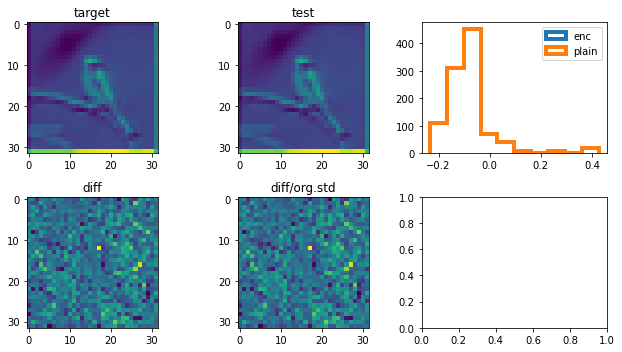

Scale 50.0
chain index 12
expected chain index = 12


In [14]:
util.plot_diff(org_tt1, tmp1, 32,32, ch=5, unpad=0)
util.check_ctxt(tmp1[0])
print("expected chain index = 12")

### 0.2 Convolution

똑같이 나옴. my_conv2D는 문제 없고, 테두리 값 때문에 생기는 문제! 

In [15]:
print(org_model.conv_layer2.weight.shape)
print(org_model.conv_layer2)

org_tt2 = org_model.conv_layer2(org_tt1)

tmp2, _nh2, _nw2 = my_conv2D_FHE(sec, tmp1, nh, nw, org_model.conv_layer2) # list of ctxts

torch.Size([32, 16, 3, 3])
Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
Output image size 32 32


average diff -0.000 sigma


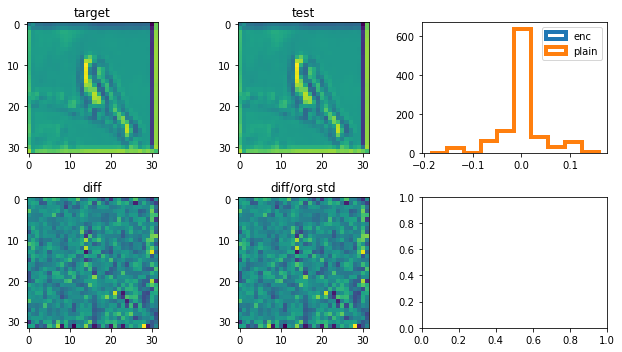

Scale 50.0
chain index 10
expected chain index = 10


In [16]:
util.plot_diff(org_tt2, tmp2, 32,32, ch=1, unpad=0)
util.check_ctxt(tmp2[3])
print("expected chain index = 10")

### 0.3 AVG pooling

In [17]:
org_tt3 = org_model.pool(org_tt2)

#tmp2_ = [sec.encrypt(this_channel.detach().numpy().ravel()) for this_channel in org_tt2[0]]
tmp3, nh2, nw2 = fhe_avg_pool(sec, tmp2,
                                nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=1) # list of ctxts


Output image size 16 16


average diff -0.000 sigma


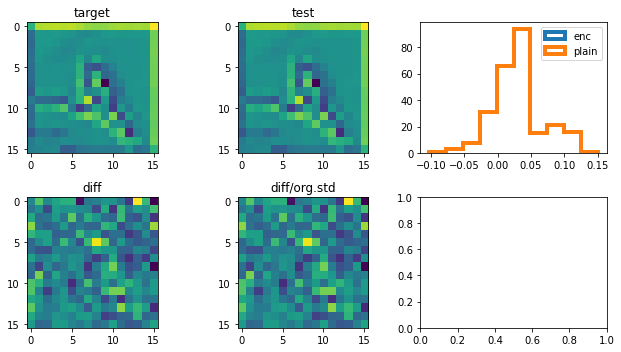

Scale 50.0
chain index 8
expected chain index = 8


In [18]:
util.plot_diff(org_tt3, tmp3, 32,32, ch=0, stride=(2,2), unpad=0)
util.check_ctxt(tmp3[0])
print("expected chain index = 8")

### 0.4 Convolution (After average pooling!)

1. rotation 맞는건가..?

2. padding mask가 dilated 상태에서도 맞는지 확인 필요

3. 

In [19]:
print(org_model.conv_layer3.weight.shape)
print(org_model.conv_layer3)

torch.Size([32, 32, 3, 3])
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)


In [20]:
util.check_ctxt(tmp3[0])

Scale 50.0
chain index 8


In [21]:
## dilate org tensor
tmp3_ = []
for oo in org_tt3[0]:
    zz = np.zeros(1024).reshape(32,32)
    zz[::2,::2] = oo.detach().numpy()
    tmp3_.append(sec.encrypt(zz.ravel()))

In [22]:
org_tt4 = org_model.conv_layer3(org_tt3)

In [23]:
sec.decrypt(tmp3[0])[:1024].reshape(32,32)[::2,::2]

array([[ 0.05961405,  0.11995285,  0.12263787,  0.12426366,  0.12279209,
         0.12536345,  0.11863384,  0.10979445,  0.10636956,  0.10813021,
         0.11356047,  0.11627437,  0.11491148,  0.11618061,  0.11477521,
         0.15096249],
       [-0.01180482,  0.03290752,  0.03230605,  0.03380307,  0.03120624,
         0.02885479,  0.01937611,  0.01711867,  0.02480503,  0.0320387 ,
         0.03293705,  0.0315988 ,  0.03158806,  0.03266371,  0.0322904 ,
         0.09515731],
       [-0.0151823 ,  0.03275396,  0.03360183,  0.03083634,  0.02354932,
         0.01948538,  0.02200308,  0.02847734,  0.02701094,  0.02395417,
         0.02607772,  0.0251937 ,  0.02521809,  0.02714615,  0.0282539 ,
         0.09638341],
       [-0.01132057,  0.03224942,  0.02866328,  0.02186739,  0.01448111,
         0.01621093,  0.02736624,  0.02433591,  0.02098618,  0.01862494,
         0.02393619,  0.0259859 ,  0.02550855,  0.0260854 ,  0.02851049,
         0.0989889 ],
       [-0.0073149 ,  0.02953631,  0

In [24]:
tmp4, _nh2, _nw2 = my_conv2D_FHE(sec, tmp3, nh, nw, org_model.conv_layer3,
                                stride_in=2) # list of ctxts

Output image size 16 16


좋아, conved + bias = org_tt4 나옴! 

average diff 0.000 sigma


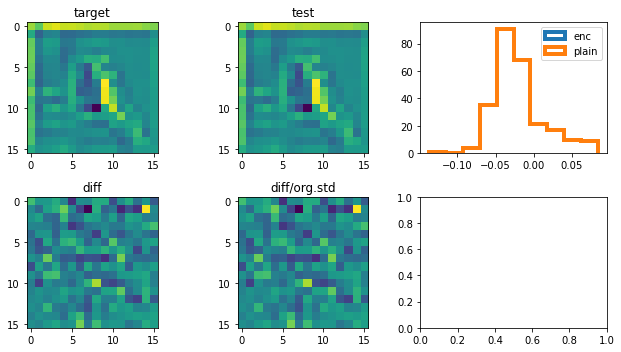

Scale 50.0
chain index 6
expected chain index = 8


In [30]:
util.plot_diff(org_tt4, tmp4, 32,32, ch=0, stride=(2,2))
util.check_ctxt(tmp4[0])
print("expected chain index = 8")

Convolaution과 AVG pool의 striding을 동일하게 맞출 것. 

### 0.4 BN

In [31]:
print(org_model.bn1)

## 이전에 문제 있음!
#########################################
# tmp4_ = []
# for oo in org_tt4[0]:
#     zz = np.zeros(1024).reshape(32,32)
#     zz[::2,::2] = oo.detach().numpy()
#     tmp4_.append(sec.encrypt(zz.ravel()))

#########################################


# FHE
tmp5 = fhe_bn(sec, tmp4, org_model.bn1)

# Torch
org_tt5 = org_model.bn1(org_tt4)

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


average diff 0.000 sigma


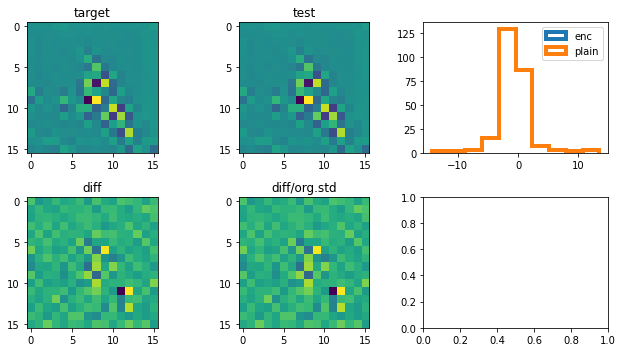

Scale 50.0
chain index 5
expected chain index = 10


In [32]:
util.plot_diff(org_tt5, tmp5, 32,32, ch=3, unpad=0, stride=(2,2))
util.check_ctxt(tmp4[0])
print("expected chain index = 10")

diff는 거의 0.

- Conv에서는 multByConst만 있으나 이거도 Scale을 똑같이 증가시킴
- C_mult와 다른 점은, multByConst 후에는 relinearization은 필요 없고 rescale만 해주면 됨.  
- 연산을 거친 ctxt의 level과 새로 encoding된 ptxt의 level이 다름. scale도 같고, level도 맞아야함. (mod_switch_to_inplace)

### 0.5 activation   

f(x) ~ x^4 인 계산을 두 번 나누어서 하는 건 문제가 없음!  
한번에 x^8까지 계산하는게 문제임. 


1. 높은 차수의 polynomial을 임의의 낮은 차수로 factoring하는 방법은...?  
coeff가 real number 이므로 어차피 손으로는 못 함.  
https://www.coursera.org/lecture/converter-control/8-1-8-analytical-factoring-of-higher-order-polynomials-6vTUc
근사적인 방법이 있는 듯?  

이전에 참조하려다 이해 못했던 그 논문도 비슷한 생각으로 진행했던 거였나 봄. 


2. 애초에 왜 polyeval 함수 계산이라고 왜 문제가 되어야하나. 어차피 한 번에 한 차수씩 곱하지 않나? 


In [35]:
util.check_ctxt(tmp5[0])

Scale 50.0
chain index 5


In [38]:
# fhe
ff = approx_sign(5)
tmp5 = [do_bootstrap(sec, tmp) for tmp in tmp5]
tmp6 = approx_relu_fhe(sec, calgo, tmp5, ff, repeat=4, xfactor=20)

# pytorch
org_tt6 = org_model.activation(org_tt5)

Org range -5.45341216931778 3.366198642325281
Bootstrapped 0 2
Org range -7.440981853691431 2.647756916147223
Bootstrapped 1 2
Org range -7.969157684523973 7.587872663968
Bootstrapped 2 2
Org range -14.298876855443314 13.479208518204153
Bootstrapped 3 2
Org range -2.614987833577746 3.3298373147214715
Bootstrapped 4 2
Org range -5.082729660235936 4.579008486046716
Bootstrapped 5 2
Org range -6.903184087630228 4.05681983440004
Bootstrapped 6 2
Org range -4.9625614498957145 4.377396285083228
Bootstrapped 7 2
Org range -6.862920112899262 5.127501247093805
Bootstrapped 8 2
Org range -3.749570813919931 3.5978863581877985
Bootstrapped 9 2
Org range -10.948969334444827 11.235270646450026
Bootstrapped 10 2
Org range -1.5561575394662408 2.4155573957162053
Bootstrapped 11 2
Org range -4.514621142488206 5.625338286309136
Bootstrapped 12 2
Org range -1.2780327537958014 5.107516927380562
Bootstrapped 13 2
Org range -3.30300893536962 3.7146152147821487
Bootstrapped 14 2
Org range -4.225705417327413 5

average diff -0.095 sigma


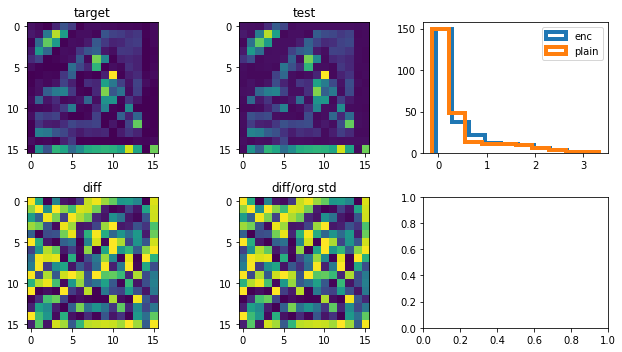

Scale 50.0
chain index 2
expected chain index = 3


In [41]:
util.plot_diff(org_tt6, tmp6, nh, nw, ch=4, unpad=0, stride=(2,2))
util.check_ctxt(tmp6[0])
print("expected chain index = 3")

Not too bad. 
Most of the errors are from the incorrect padding. (Check with offset=3)

### 6. AvgPool

두 번째 stride가 잘 작동함!

In [42]:
util.check_ctxt(tmp6[0])

Scale 50.0
chain index 2


In [43]:
org_tt7 = org_model.pool(org_tt6)

tmp6 = [do_bootstrap(sec, tmp) for tmp in tmp6]
util.check_ctxt(tmp6[0])

tmp7, _nh3, _nw3 = fhe_avg_pool(sec, tmp6, nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=2) # list of ctxts

Scale 50.0
chain index 14
Output image size 8 8


average diff -0.062 sigma


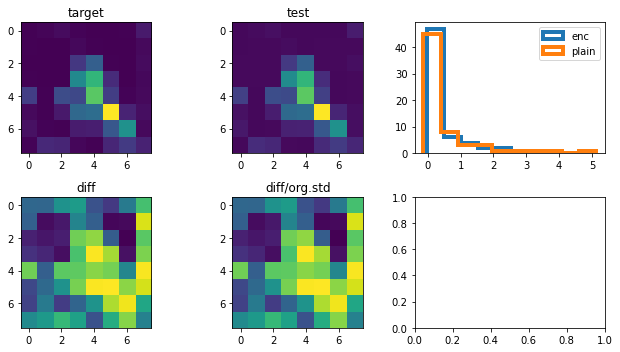

Scale 50.0
chain index 12
expected chain index = 3


In [44]:
util.plot_diff(org_tt7, tmp7, nh, nw, ch=3, unpad=0, stride=(4,4))#, shift=1)
util.check_ctxt(tmp7[0])
print("expected chain index = 3")

모양에 shift는 없지만 틀린듯.

## 8. Conv4

In [45]:
print(org_model.conv_layer4.weight.shape)
print(org_model.conv_layer4)

## 이전에 문제 있음! 2222
#########################################
# tmp7_ = []
# for oo in org_tt7[0]:
#     zz = np.zeros(1024).reshape(32,32)
#     zz[::4,::4] = oo.detach().numpy()
#     tmp7_.append(sec.encrypt(zz.ravel()))

#########################################

tmp8, _nh3, _nw3 = my_conv2D_FHE(sec, tmp7, nh, nw, org_model.conv_layer4,
                                stride_in=4) # list of ctxts

org_tt8 = org_model.conv_layer4(org_tt7)

torch.Size([64, 32, 3, 3])
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Output image size 8 8


average diff 0.057 sigma


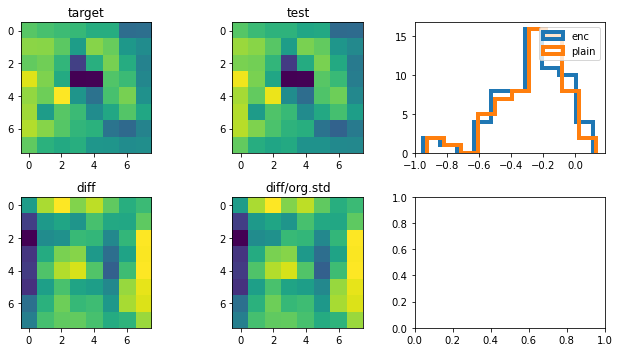

Scale 50.0
chain index 10


In [46]:
util.plot_diff(org_tt8, tmp8, nh, nw, ch=4, unpad=0, stride=(4,4))
util.check_ctxt(tmp8[0])

## Conv5

In [47]:
print(org_model.conv_layer5.weight.shape)
print(org_model.conv_layer5)
tmp9, _nh3, _nw3 = my_conv2D_FHE(sec, tmp8, nh, nw, org_model.conv_layer5,
                                stride_in=4) # list of ctxts

org_tt9 = org_model.conv_layer5(org_tt8)

torch.Size([64, 64, 3, 3])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
Output image size 8 8


average diff -0.014 sigma


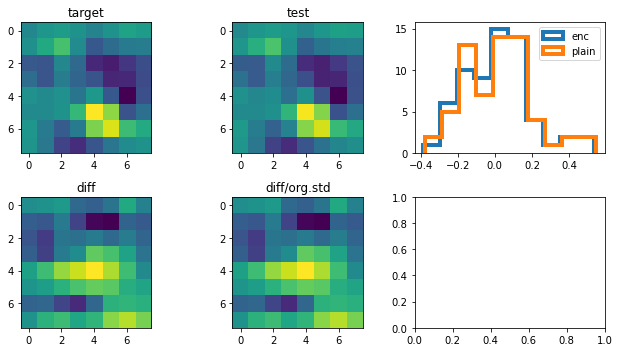

Scale 50.0
chain index 8


In [48]:
util.plot_diff(org_tt9, tmp9, nh, nw, ch=29, unpad=0, stride=(4,4))
util.check_ctxt(tmp9[0])

In [49]:
import pickle

intermediate = []
for tt in tmp9:
    intermediate.append(sec.decrypt(tt)[:1024])
    
pickle.dump(intermediate, open("AfterConv5.pickle", "wb"))



## Pool

In [50]:
org_tt10 = org_model.pool(org_tt9)

util.check_ctxt(tmp9[0])

tmp10, _nh4, _nw4 = fhe_avg_pool(sec, tmp9, nh, nw, 
                                kernel_size=org_model.pool.kernel_size, 
                                stride_in=4) # list of ctxts

Scale 50.0
chain index 8
Output image size 4 4


average diff 0.021 sigma


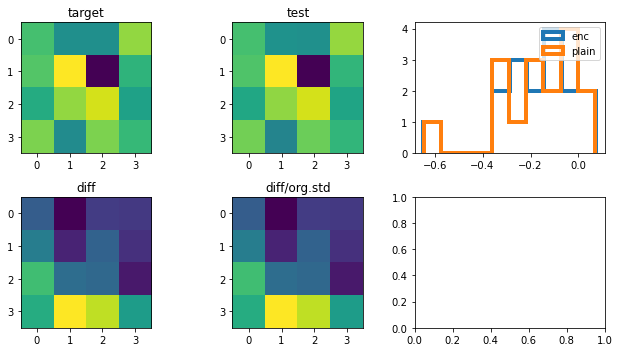

Scale 50.0
chain index 6


In [53]:
util.plot_diff(org_tt10, tmp10, nh, nw, ch=5, unpad=0, stride=(8,8))
util.check_ctxt(tmp10[0])

# Reshape

In [52]:
pickle.dump([org_model.fc1.weight,org_model.fc1.bias], open("fc1.pickle", "wb"))
pickle.dump(org_tt10, open("org_tt10.pickle", "wb"))

In [192]:
org_tt10 = org_tt10.reshape(org_tt10.size(0),-1)

In [185]:
util.check_ctxt(tmp10[0])

Scale 50.0
chain index 6


In [ ]:
# Reshape
#tmp10_ = [do_bootstrap(sec, tt) for tt in tmp10]


In [196]:
dec = sec.decrypt(output)

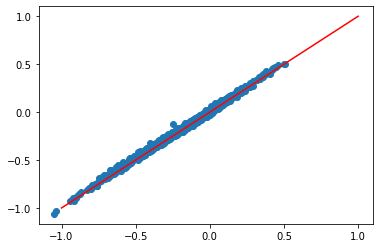

In [197]:
plt.scatter(dec[:1024], org_tt10.detach().numpy())
plt.plot([-1,1], [-1,1], color="r")
plt.show()

In [198]:
pickle.dump(dec, open("before_FC1.pickle", "wb"))

# FC1

1 x 1024  * 1024 * 128


In [199]:
util.check_ctxt(output)

Scale 50.0
chain index 5


In [238]:
# But only 128 slots will be used
tmp_fc1 = sec.encrypt(np.zeros(sec.nslots)) 


ind_put = 0
for ww in org_model.fc1.weight.detach().numpy():
    feature_weight = sec.multByConst(output, ww, rescale=True)
    
    # Sum
    reduced = calgo.reduce(feature_weight, 11)

    mask = np.zeros(sec.nslots)
    mask[ind_put] = 1.
    masked = sec.multByConst(reduced, mask, rescale=True)

    if ind_put == 0: sec.match_mod(tmp_fc1, masked)
    sec.add(tmp_fc1, masked, inplace=True)
    ind_put += 1
        
    

bias = np.zeros(sec.nslots)
bias[:128] = org_model.fc1.bias.detach().numpy()

sec.addConst(tmp_fc1, bias, inplace=True)

In [276]:
org_11 = org_model.fc1(org_tt10)

zz = org_11.detach().numpy()

In [277]:
dec = sec.decrypt(tmp_fc1)[:128]

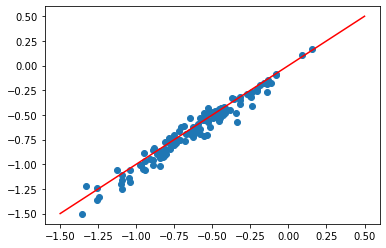

In [278]:
plt.plot([-1.5,0.5],[-1.5,0.5], color='r')
plt.scatter(zz, dec)

# Activation

In [273]:
sec.decrypt(tmp_fc1)[:128]

array([-0.26539888, -0.14681442, -0.52176448, -0.69184401, -0.6839569 ,
       -0.31536554, -0.54712285, -0.80189431, -1.33369526, -0.96100306,
       -1.04722841, -0.69640661, -0.48710731, -0.53160925, -0.75728381,
       -0.87168129, -0.23698366, -0.84858187, -0.93673896, -0.30810013,
       -0.79842145, -0.88413715, -0.35147411, -1.15967006, -0.38805695,
       -0.45334237, -1.5035864 , -0.91171666, -1.13453658, -0.78472372,
       -0.48655968, -0.53567926, -0.17529271, -1.17735443, -0.62491408,
       -0.847946  , -0.09015878, -0.76154528, -1.3624712 , -1.00400001,
       -1.0104166 , -0.65466621, -1.23693635, -1.06124188, -0.47572382,
       -0.4919329 , -0.67538074, -0.69437903, -0.44495904, -1.00282966,
       -1.25362501, -0.71723953, -0.72389429, -0.916015  , -0.51676568,
       -0.94848668, -0.64402175, -0.28742529, -0.90080194, -0.50013787,
       -0.4952918 , -0.88949567, -0.96466359, -0.5409006 , -0.09655267,
       -0.50098217, -0.46909678, -0.33165826, -0.75519237, -0.57

## 왜 여기서 안 맞아......;;

domain이 0에 너무 가까이 있음..

ORG 모델의 activation을 F.relu가 아니고 approx로 했었음.... 그럼 안 되지 않나? 

Bootstrapped 0 2
Bootstrapped 0 4


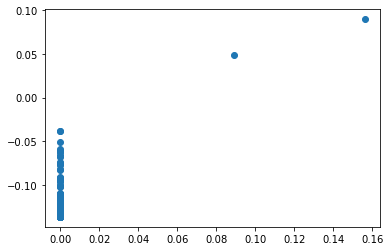

In [322]:
ff2 = approx_sign(7)
fake_ctx = [sec.encrypt(org_11[0].detach().numpy())]
fake_11 = approx_relu_fhe(sec, calgo, fake_ctx, ff2, repeat=5, xfactor=2)

dec = sec.decrypt(fake_11[0])[:128]
plt.scatter(dec, zz)

In [326]:
#org_11_1 = org_model.activation(org_11)
org_11_1 = F.relu(org_11)

In [327]:
org_11_1

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0891, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1559, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [285]:
tmp_fc1_ = [do_bootstrap(sec, tmp_fc1)]

tmp_fc11 = approx_relu_fhe(sec, calgo, tmp_fc1_, ff, repeat=4, xfactor=15)

# pytorch
org_11_1 = org_model.activation(org_11)

In [287]:
dec = sec.decrypt(tmp_fc11[0])[:128]
zz = org_11_1[0].detach().numpy()

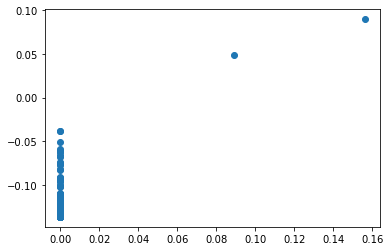

In [296]:
dec = sec.decrypt(fake_11[0])[:128]
plt.scatter(dec, zz)

# FC2

1 x 128  * 128 x 10

In [242]:
util.check_ctxt(tmp_fc1)

Scale 50.0
chain index 3


In [ ]:
# But only 10 slots will be used
tmp_fc2 = sec.encrypt(np.zeros(sec.nslots)) 

ind_put = 0
for ww in org_model.fc2.weight.detach().numpy():
    feature_weight = sec.multByConst(tmp_fc1, ww, rescale=True)
    
    # Sum
    reduced = calgo.reduce(feature_weight, 7) # 7 or 8?

    mask = np.zeros(sec.nslots)
    mask[ind_put] = 1.
    masked = sec.multByConst(reduced, mask, rescale=True)
    
    if ind_put == 0: sec.match_mod(tmp_fc2, masked)
    sec.add(tmp_fc2, masked, inplace=True)
    ind_put += 1
        
    

bias = np.zeros(sec.nslots)
bias[:10] = org_model.fc2.bias.detach().numpy()

sec.addConst(tmp_fc2, bias, inplace=True)

In [246]:
result = sec.decrypt(tmp_fc2)[:10]
print(result)

[ 0.7740644  -1.56332919 -2.38210231 -0.10702111 -0.1996476   0.64727898
 -2.15798602  0.51687765  1.99887281  2.73043793]


In [329]:
torch.argmax(org_model.fc2(org_11_1)) # 정답은 2... 

tensor(4)

In [10]:
org_result = org_model(img_tensor)

In [13]:
org_result # 원래 모델도 틀림.. ㅎㅎ 

tensor([[ 6.9884, -8.8124,  5.6470,  4.2776, -2.7717, -0.2326,  0.0269, -5.2098,
          2.9961, -2.8027]], grad_fn=<AddmmBackward0>)

# 여러개 예제를 확인해봐야 할 듯. 

마지막 activation에서 대부분 0이 나오는거 큰 문제 아닌 것 같음.   
- F.relu인 org_model로 무슨 값 나오나 확인해보기..

In [253]:
torch.argmax(org_result)

tensor(0)

In [35]:
# One block = ((Conv2D - BN - ReLU - Conv2D - Bn ) + () ) ReLU

def to_numpy(tensor):
    return tensor.detach().numpy()

Everything is good!